In [1]:
import msprime as ms
import numpy as np
from IPython.display import SVG, display
import matplotlib.pylab as plt
%matplotlib inline  
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"]="3"

# Coalescent simulations using msprime
msprime (Kelleher et al. 2016, Bioinformatics) is a coalescent simulator that reimplements and extends the widely used ms (Hudson 2002, Bioinformatics) using a python interface. We will use it here to do some coalescence simulation and investigate the effects of population size changes.

 <div class="alert alert-block alert-danger">
 **Iterators**
Most output of msprime are _iterators_, i.e. objects that are supposed to be processed by iterating over them using a loop. This approach is highly computationally efficient, because simulation results are not stored in memory longer than necessary. However, it has the drawback that slightly more effort is required compared to working with an object in memory, and we re-simulate a few times throughout this tutorial.
</div>

## 1. Basic Simulation and plotting
For simulating, we use the function `ms.simulate`. It has many options (type `?ms.simulate` for inline docs), but requires at least a `sample_size` parameter to be set. So everyone gets the same tree, we also set a `random_seed`.

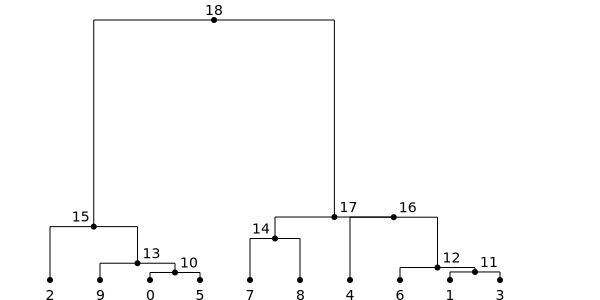

In [2]:
tree_sequence = ms.simulate(sample_size=10, random_seed=4)
tree = tree_sequence.first()
display(SVG(tree.draw(width=600, height =300)))

##### Notes
- `ms.simulate` returns a `TreeSequence` object (or an iterator over `TreeSequence` objects if we have multiple replicates, as in many of the following examples). 
- A `TreeSequence` records how the tree changes across a simulated stretch of the genome with recombination.
- As we will not discuss recombination today, all our simulations wil have exactly one tree, which we get using the `TreeSequence.first()` method.
- `tree.draw()` draws a tree. `SVG` creates an SVG object and `display` forces rendering in jupyter

## 2. Variation in tree shape and size
As mentioned in the lecture, coalescent trees are stochastic objects and differ greatly between each iteration of the process. To visualize that, we can generate several replicates, using the `num_replicates` argument to `ms.simulate`. We now have to iterate over the resulting trees using a `for`-loop:

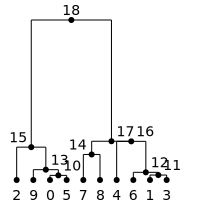

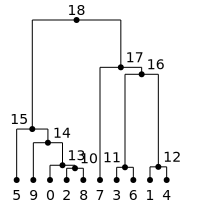

In [3]:
tree_sequence_iterator = ms.simulate(sample_size=10, num_replicates=2, random_seed=4)
for tree_sequence in tree_sequence_iterator:
    tree = tree_sequence.first()
    display(SVG(tree.draw()))

## 3. Properties of the tree
Next, let us look at some of the basic properties of the tree, how we can extract them from `msprime`, and how they compare to the theoretical expectations. `msprime` gives us access to this through its API which allows great flexibility. As a drawback, we need to write some custom code to access them.

### 3.1 Total tree length
First, let us look at the total size of the genealogy, $T_{tot}$. Remember, in the lecture we showed that 
$$\mathbb{E}T_{tot} = 2\sum_{i=1}^{n-1}\frac{1}{i}$$, where $n$ is the sample size. Can we confirm this using simulations? To do so, we need i) a function `get_expected_ttot(n)` giving us the expected tree length for a sample of size `n`. We also need a function `get_observed_ttot(tree_sequence)` to get the corresponding quantity from our simulations.

In [4]:
def get_expected_ttot(n):
    return 2 * sum(1/i for i in range(1,n))
def get_observed_ttot(tree_sequence):
    tree = tree_sequence.first()
    return tree.total_branch_length

In [5]:
print("n\tobs\texpexted")
for n in [2, 10, 20, 50, 100, 200, 500, 1000]:
    tree_sequence_iterator = ms.simulate(sample_size=n, num_replicates=1000, random_seed=4)
    obs_ttot = [get_observed_ttot(tree_sequence) for tree_sequence in tree_sequence_iterator]
    print("%d\t%.4f\t%.4f" % (n, np.mean(obs_ttot), get_expected_ttot(n)))

n	obs	expexted
2	4.1344	2.0000
10	11.1878	5.6579
20	13.8258	7.0955
50	17.6146	8.9584
100	20.9682	10.3548
200	23.7313	11.7461
500	27.1586	13.5816
1000	30.0739	14.9689


 <div class="alert alert-block alert-warning">
 **Question 1**: Why/how do these values differ?
 </div>

### 3.2 Coalescence times:
Second, let us look at the coalescence times. Remember that for times where there are $n$ lineages, the coalescence times are distributed exponentially:  $$T_n \sim \text{Exp}\left[\binom{n}{2}\right]$$
Unless the branch length, the coalescence times are not directly reported by `msprime`. However, what _is_ reported (in the `node.time` attribute) are the times when new lines are created. This is either the sampling time (0, backwards in time, or when coalescence times happened). Thus, we need to extract the lineages by iterating over all non-sample nodes and calculating the differences between the times, which I implemented in the `get_coalescence_times` function:

In [6]:
def get_coalescence_times(tree_sequence):
    """get coalescence times from a tree_sequence object"""
    times = [0]
    for node in tree_sequence.nodes():
        if not node.is_sample():
            times.append(node.time)
    return np.diff(times)

sample_size = 8
tree_sequence_iterator = ms.simulate(sample_size=sample_size, num_replicates=10000, random_seed=4) #simulate 10k trees
coalescence_times = [get_coalescence_times(tree_sequence) for tree_sequence in tree_sequence_iterator]


We can then look at the results by calculating the mean and variance in coalescence times across simulations. `numpy` provides convenient functions to this whith the `axis` keyword, `axis=0`, applies a function per row, `axis=1` per column (and similar for higher-dimensional arrays). 

In [7]:
coalescence_times = np.array(coalescence_times) #convert to numpy array for easy computation

mean_ct = np.mean(coalescence_times, axis=0) #get rowwise mean, i.e. mean of all the same coalescence times
expected_coal_times = [2*2/i/(i-1) for i in range(2,1 + sample_size)] #factor of two introduced for scaling
print("Time\tT_Obs\tExp")
for i, time in enumerate(mean_ct):
    print("T%d\t%.4f\t%.4f" %( sample_size-i, time, expected_coal_times[sample_size - 2 - i]))

Time	T_Obs	Exp
T8	0.0723	0.0714
T7	0.0940	0.0952
T6	0.1350	0.1333
T5	0.1989	0.2000
T4	0.3264	0.3333
T3	0.6714	0.6667
T2	1.9975	2.0000


<div class="alert alert-block alert-warning">
 **Question 2:**: What do we expect to see for the variance? (Hint: `?np.var`). Write some code to compare the variance in the simulation with the one we would expect based on theory
 </div>
 
 #### Visualization
 We can also make boxplots with `matplotlib` (which requires slightly more effort). The following code will create two

/home/bpeter/.local/lib/python3.5/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


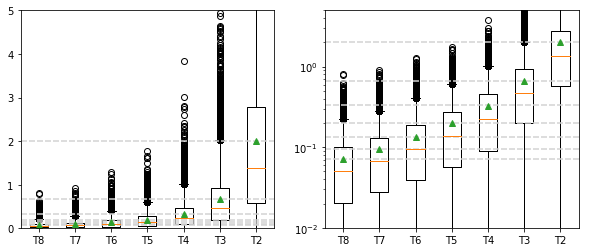

In [8]:
cts = np.hsplit(coalescence_times,coalescence_times.shape[1]) #split array into rows with same coal time between reps

fig = plt.figure(figsize=[10,4]) #create figure
ax = fig.add_subplot(1, 2, 1) #create panel 1
ax.set_ylim(1e-2,5)
ax.boxplot(cts, showmeans=True, labels=["T%d" % i for i in range(sample_size,1,-1)])
for t in expected_coal_times:
    ax.axhline(t, dashes=[3,1], color="lightgrey")
ax = fig.add_subplot(1, 2, 2) #create panel 2 with log-scale
ax.set_yscale('log')
ax.set_ylim(1e-2,5)
ax.set_xticks([1,2])
ax.boxplot(cts, showmeans=True, labels=["T%d" % i for i in range(sample_size,1,-1)])
for t in expected_coal_times:
    ax.axhline(t, dashes=[3,1], color="lightgrey")
fig.show()

We observe that the coalescence times with many lineages are extremely short. So that most of the time is spent with very few lineages. As the $T_n$ are exponential random variables, the boxplots are highly skewed, with the mean (triangle) much larger than the median.

## 4. Adding mutations
We can easily add mutations from an infinite sites model by supplying a `mutation_rate` parameter to `msprime.simulate`. The resulting visualization shows on which branch mutations fall. Each sample _subtending_ a mutation will have the mutant allele at that particular site. 
- The mutations are highly random, there are 9 mutations on the left side, but only one on the right side of the tree, even though the lengths are similar!
- The tree topology here is identical to the one in the very first simulation figure we did. This is because the same seed is used, and mutations are simulated _after_ the tree, with the number of mutations on each branch being distributed as $\text{Poisson}(t_i)$, where $t_i$ is the length of a branch

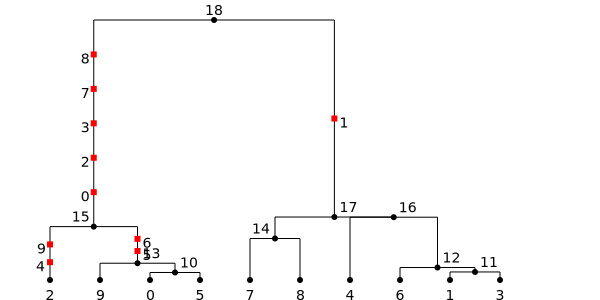

In [9]:
tree_sequence = ms.simulate(sample_size=10, random_seed=4, mutation_rate=.5)
tree = tree_sequence.first()
display(SVG(tree.draw(width=600, height =300)))

<div class="alert alert-block alert-warning">
 **Question 3:** Implement the function `get_expected_segsites` to calculate the expected number of segregating sites in a sample, and the function `get_observed_segsites` to get the number of mutations from a `TreeSequence` object. See if your expectation matches predictions. (Hint: `?tree_sequence.num_mutations`)
 </div>

In [10]:
def get_expected_segsites(n, theta):
    """To be implemented"""
    return -1
def get_observed_segsites(tree_sequence):
    """To be implemented"""
    return -1

In [11]:
print("n\ttheta\tobs\texpexted")
sample_sizes = [2, 20, 200]
thetas = [.1, 1, 10, 100]
for n in sample_sizes:
    for theta in thetas:
        tree_sequence_iterator = ms.simulate(sample_size=n, num_replicates=1000, random_seed=4, mutation_rate=theta)
        obs_S = [get_observed_segsites(tree_sequence) for tree_sequence in tree_sequence_iterator]
        print("%d\t%.2f\t%.2f\t%.4f" % (n, theta, np.mean(obs_S), 2 * get_expected_segsites(n, theta)))

n	theta	obs	expexted
2	0.10	-1.00	-2.0000
2	1.00	-1.00	-2.0000
2	10.00	-1.00	-2.0000
2	100.00	-1.00	-2.0000
20	0.10	-1.00	-2.0000
20	1.00	-1.00	-2.0000
20	10.00	-1.00	-2.0000
20	100.00	-1.00	-2.0000
200	0.10	-1.00	-2.0000
200	1.00	-1.00	-2.0000
200	10.00	-1.00	-2.0000
200	100.00	-1.00	-2.0000


## 5. Demographic history
All calculations discussed so far assume a highly idealized population, with random mating and constant size through its history. This is, of course, highly unrealistic, as populations are spatially structured and able to adapt to changing environments. Much of coalesence theory is concerned with understanding and learning from these deviations from expectations to learn about population structure, population size changes and the effects of natural selection. 

One of the easiest ways to introduce history is through exponential growth, where a population grows at a constant rate $\alpha$. In `msprime`, this means we have to first create a `PopulationConfiguration`-object that defines the sample size and growth (type `?ms.PopulationConfiguration` for full docs).

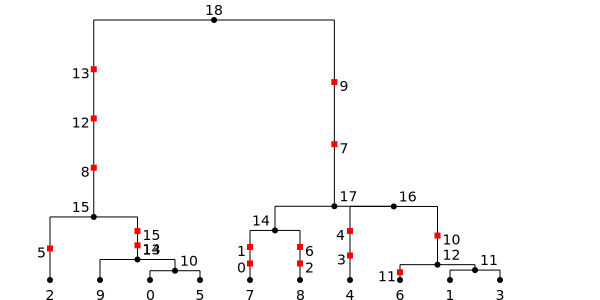

In [12]:
pop_conf = ms.PopulationConfiguration(sample_size=10, growth_rate=.1)
tree_sequence = ms.simulate(population_configurations=[pop_conf], random_seed=4, mutation_rate=1)
tree = tree_sequence.first()
display(SVG(tree.draw(width=600, height =300)))

<div class="alert alert-block alert-warning">
**Question 4:** By using the same seed as above, we again obtain the same topology as in the first example. Do you notice any changes?
 </div>
 ### 5.1 The genotype matrix
Furthermore, we can look at a compact representation of genotypes by calling `tree_sequence.genotype_matrix()`. This function will create a matrix where each column represents an individual, and each row a specific site. A `0` means the state is ancestral, whereas a `1` refers to a derived state, i.e. that the sampled individual subtends that mutation.

In [13]:
tree_sequence.genotype_matrix()

array([[0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 1, 0, 1, 1, 0, 1, 1, 1, 0],
       [1, 0, 1, 0, 0, 1, 0, 0, 0, 1],
       [0, 1, 0, 1, 1, 0, 1, 1, 1, 0],
       [0, 1, 0, 1, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [1, 0, 1, 0, 0, 1, 0, 0, 0, 1],
       [1, 0, 1, 0, 0, 1, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 1, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 1, 0, 0, 0, 1]], dtype=uint8)


 
 <div class="alert alert-block alert-warning">
**Question 5:** Based on what you know about the relationship between population size, tree length and number of mutations, would you expect more or less mutations? And would you expect proportionally more rare or common variants?
 </div>
 
  <div class="alert alert-block alert-warning">
**Question 6:** To test this, run some simulations using different growth rates and compare the number of segregating sites with the expectation from a constant-sized population.
 </div>

In [14]:
def simulate_growing_population(growth_rate, sample_size, **kwargs):
    """
    Simulate a growin population using msprime. Required arguments are 
     - growth_rate (float): growth rate of population backwards in time
     - sample_size (int): number of samples to be simulated
     - mutation_rate (float): mutation_rate per unit time
     
     Returns:
     - an iterator over msprime.TreeSequence objects performing the simulation
    """
    pop_conf = ms.PopulationConfiguration(sample_size=sample_size, growth_rate=growth_rate)
    return ms.simulate(population_configurations=[pop_conf], **kwargs)
    

print("n\talpha\tobs\texpexted")
sample_sizes = [2, 20, 200]
theta = 10
growth_rates = [0, .01, .1, 1]
for n in sample_sizes:
    for g in growth_rates:
        tree_sequence_iterator = simulate_growing_population(growth_rate=g, sample_size=n, mutation_rate=theta, 
                                                            num_replicates=500)
        obs_S = [get_observed_segsites(tree_sequence) for tree_sequence in tree_sequence_iterator]
        print("%d\t%.2f\t%.2f\t%.4f" % (n, g, np.mean(obs_S), 2 * get_expected_segsites(n, theta)))

n	alpha	obs	expexted
2	0.00	-1.00	-2.0000
2	0.01	-1.00	-2.0000
2	0.10	-1.00	-2.0000
2	1.00	-1.00	-2.0000
20	0.00	-1.00	-2.0000
20	0.01	-1.00	-2.0000
20	0.10	-1.00	-2.0000
20	1.00	-1.00	-2.0000
200	0.00	-1.00	-2.0000
200	0.01	-1.00	-2.0000
200	0.10	-1.00	-2.0000
200	1.00	-1.00	-2.0000


# Part 2: Some applications of the coalescent
In this second step, we are going to look at some ways the coalescent can be used to interpret data. Let us start with the site frequency spectrum (SFS), the histogram of mutations at a given abundance in a sample.

To compute the SFS in `msprime`, we have to use the `BranchLengthStatCalculator`-module, which allows to calculate the SFS based on the lengths of all the branches. From this, we could easily sample mutations by taking independent Poisson random variables.

In [15]:
sample_size=10
tree_sequence_iterator = ms.simulate(sample_size=sample_size, random_seed=4, num_replicates=1000)
sfs = np.zeros(sample_size)
for tree_sequence in tree_sequence_iterator:
    s = ms.BranchLengthStatCalculator(tree_sequence)
    sfs += s.site_frequency_spectrum(sample_set=list(s.tree_sequence.first().samples()))[0]

sfs_exp = 1 / np.arange(1,sample_size)
  
print("freq\texpected\tobserved")
for ij in zip(np.arange(1, 10), sfs_exp / sum(sfs_exp), sfs / sum(sfs)):
    print("%d\t%.3f\t\t%.3f" % ij)

freq	expected	observed
1	0.353		0.354
2	0.177		0.180
3	0.118		0.118
4	0.088		0.088
5	0.071		0.071
6	0.059		0.058
7	0.050		0.049
8	0.044		0.045
9	0.039		0.036


 <div class="alert alert-block alert-warning">
**Question 7:** Calculate the SFS based on simulations using the exponentially growing population from Exercise 5. What would you expect? Does the simulation match your expectation?
 </div>

In [16]:
"""to be implemented"""

'to be implemented'

## Population Structure
The next piece of complexity we would like to add are multiple, interacting populations. For this, we need to define a demography using a set of `msprime.PopulationConfiguration` objects that give the initial sizes of each population. For our example, we will use a very simplified human demographic model with Europeans, Africans and Neandertals:

In [17]:
EUR_POP = ms.PopulationConfiguration(sample_size=4, initial_size=.8)
AFR_POP = ms.PopulationConfiguration(sample_size=6, initial_size=1)
NEA_POP = ms.PopulationConfiguration(sample_size=2, initial_size=.1)
pop_cfg = [EUR_POP, AFR_POP, NEA_POP]

This specifies three populations with sample sizes 4, 6 and 2, respectively. Before we continue, we will set up some auxilliary variables that store which sample came from which population. These are not strictly necessary, but will make things easier for downstream analysis.

In [18]:
SS = 4, 6 ,2 #sample sizes
labels = "EUR", "AFR", "NEA"
lab_dict = {} #dict assigning samples to pops
EUR = list(range(SS[0]))
AFR = list(range(SS[0], SS[0] + SS[1]))
NEA = list(range(SS[0] + SS[1], sum(SS)))
POPS = [EUR, AFR, NEA]
c = 0
for i, l in zip(SS, labels):
    for j in range(i):
        lab_dict[c] = "%s%d" % (l, j)
        c += 1

Next, we need to specify their interactions. There are two ways we can do that: 1. specifying a migration matrix, which allows for continuous migration. Alternatively, we can define  demographic events that define pointwise admixture or merging events. We will use the latter here, using the `msprime.MassMigration` object. This will move all lineages that are present in a given deme at a given time to another deme

In [19]:
merge1 = ms.MassMigration(time=.1, source=0, dest=1)
merge2 = ms.MassMigration(time=1.,  source=2, dest=1)
demo_events = [merge1, merge2]

Once these events are defined, we can use the simulation function as we are now used to:

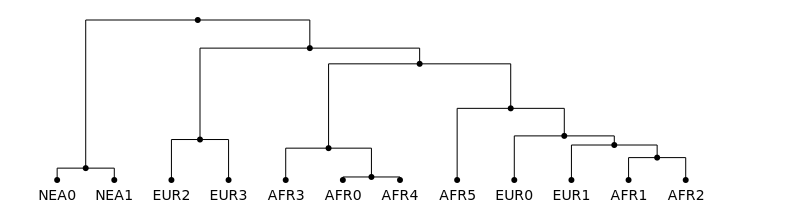

In [20]:
ts = ms.simulate(population_configurations=pop_cfg, demographic_events=demo_events)
SVG(ts.first().draw(node_labels=lab_dict, width=800))

In [21]:
tree_sequence_iterator = ms.simulate(population_configurations=pop_cfg, 
                                     demographic_events=demo_events, num_replicates=1000)
div_mat = np.zeros((1,3,3))
for tree_sequence in tree_sequence_iterator:
    s = ms.BranchLengthStatCalculator(tree_sequence)
    div_mat += s.divergence_matrix(POPS, windows=[0.0,1.])
    


In [22]:
div_mat

array([[[ 3946.32646041,  4225.55128317,  6100.52524226],
        [ 4225.55128317,  3995.2691974 ,  6103.31486339],
        [ 6100.52524226,  6103.31486339,   408.97252272]]])

## Principal component analysis

/home/bpeter/.local/lib/python3.5/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


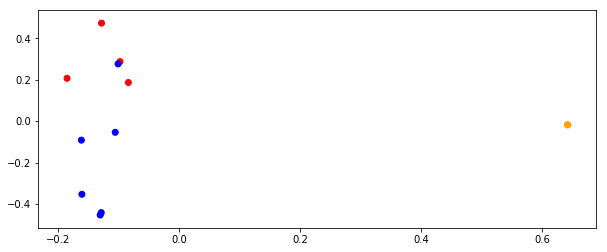

In [23]:
tree_sequence_iterator = ms.simulate(population_configurations=pop_cfg, 
                                     demographic_events=demo_events, num_replicates=200, mutation_rate=5)
genotypes = [ts.genotype_matrix() for ts in tree_sequence_iterator]
gt = np.array(np.concatenate(genotypes, 0), np.float)
snp_mean = np.mean(gt,1)
gt = (gt.transpose() - snp_mean) #normalize each snp to have mean zero
u,d, v = np.linalg.svd(gt) #perform singular value decomposition to 

fig = plt.figure(figsize=[10,4]) #create figure
ax = fig.add_subplot(1, 1, 1) #create panel
ax.scatter(u[:,0], u[:,1], c=["r","r", "r", "r", "b", "b", "b", "b", "b", "b", "orange", "orange"])
fig.show()

<div class="alert alert-block alert-warning">
**Question 8:** Create a PCA plot similar to above, but without Neandertals. How does the interpretation of the data change?
 </div>